Iniciando Análisis de Clústeres (DBSCAN)...
   -> Leyendo datos desde Postgres...
   Datos cargados: 53439 eventos.
Calculando densidades...

ANÁLISIS FINALIZADO:
   • Clústeres detectados: 80
   • Eventos aislados (ruido): 2247
   • Tasa de agrupamiento: 95.8%

TOP 10 ZONAS DE RIESGO PLUVIAL:


,precipitacion_mm,score_atlas,total_accidentes,latitud,longitud
cluster,,,,,
49,398.046083,1.0,28,19.498218,-99.152537
52,349.657211,1.0,34,19.386159,-99.244377
65,320.310676,1.0,84,19.307734,-99.211676
51,317.157097,1.0,18,19.381377,-99.252570
77,307.330323,1.0,40,19.291863,-99.124911
55,303.745601,1.0,154,19.292477,-99.151380
50,302.998519,1.0,98,19.425056,-99.199971
45,278.324946,1.0,30,19.285014,-99.128856
19,275.794449,1.0,48,19.279584,-99.173344



Archivo generado: Output_Clusters_Riesgo.csv
Mapa guardado: Mapa_Clusters_Final.png


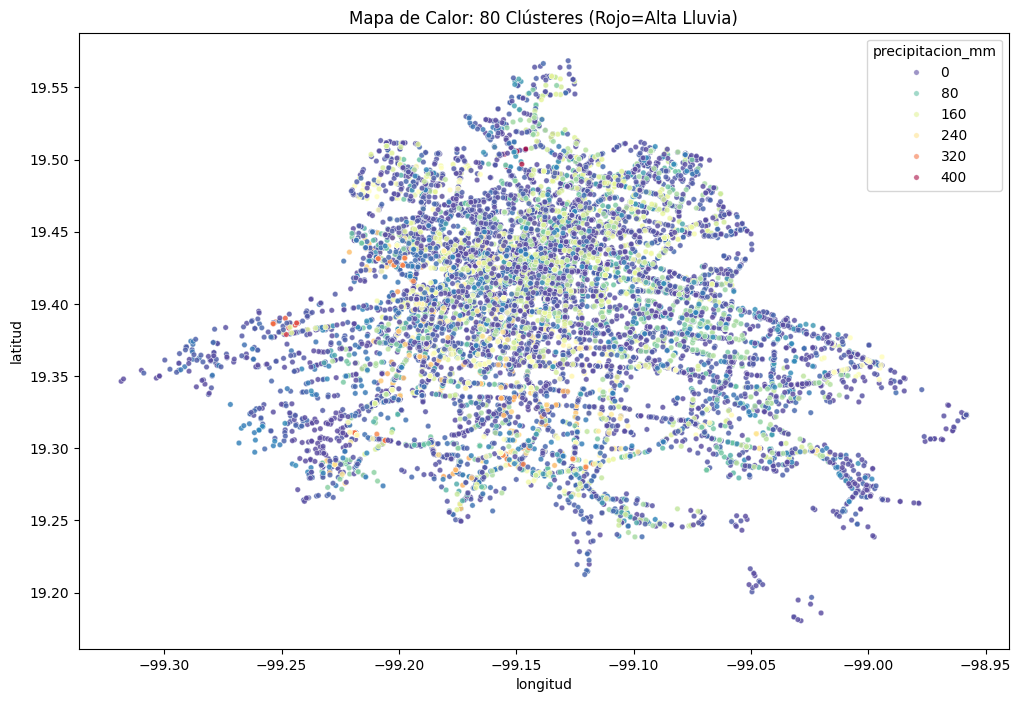

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
import urllib.parse
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# --- 1. CONEXIÓN ---
USER = "postgres"
PASSWORD = "as52"
HOST = "localhost"
PORT = "5432"
DB_NAME = "Historico_Hechos_Movilidad"

password_safe = urllib.parse.quote_plus(PASSWORD)
user_safe = urllib.parse.quote_plus(USER)
db_connection_str = f'postgresql+psycopg2://{user_safe}:{password_safe}@{HOST}:{PORT}/{DB_NAME}'
engine = create_engine(db_connection_str)

def ejecutar_dbscan_final():
    print("Iniciando Análisis de Clústeres (DBSCAN)...")
    
    # Consulta Full (Sin límite, tomamos los 53k registros)
    query = """
    SELECT 
        id_hecho, 
        latitud, 
        longitud, 
        precipitacion_mm, 
        score_atlas
    FROM mv_hechos_con_clima
    WHERE precipitacion_mm IS NOT NULL
    """
    
    try:
        print("   -> Leyendo datos desde Postgres...")
        df = pd.read_sql(query, engine)
        print(f"   Datos cargados: {len(df)} eventos.")
    except Exception as e:
        print(f"Error SQL: {e}")
        return

    if df.empty:
        print("La vista sigue vacía. Verifica el script de carga.")
        return

    # --- 2. PREPROCESAMIENTO ---
    # Normalizamos porque Lat/Lon (grados) y Lluvia (mm) tienen escalas muy distintas
    features = df[['latitud', 'longitud', 'precipitacion_mm', 'score_atlas']]
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # --- 3. EJECUCIÓN DEL ALGORITMO ---
    # Eps=0.2: Radio de búsqueda estricto (aprox 200-300m en zonas densas tras normalizar)
    # Min_samples=15: Mínimo de accidentes para considerar "Clúster"
    print("Calculando densidades...")
    dbscan = DBSCAN(eps=0.2, min_samples=15, n_jobs=-1)
    clusters = dbscan.fit_predict(features_scaled)
    
    df['cluster'] = clusters
    
    # --- 4. RESULTADOS Y EXPORTACIÓN ---
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_ruido = list(clusters).count(-1)
    
    print(f"\nANÁLISIS FINALIZADO:")
    print(f"   • Clústeres detectados: {n_clusters}")
    print(f"   • Eventos aislados (ruido): {n_ruido}")
    print(f"   • Tasa de agrupamiento: {(1 - n_ruido/len(df)):.1%}")

    if n_clusters > 0:
        # Perfilamiento de Grupos
        perfil = df[df['cluster'] != -1].groupby('cluster').agg({
            'precipitacion_mm': 'mean',
            'score_atlas': 'mean',
            'id_hecho': 'count',
            'latitud': 'mean',
            'longitud': 'mean'
        }).rename(columns={'id_hecho': 'total_accidentes'})
        
        # Ordenar por intensidad de lluvia para validar tu hipótesis
        top_riesgo = perfil.sort_values('precipitacion_mm', ascending=False).head(10)
        
        print("\nTOP 10 ZONAS DE RIESGO PLUVIAL:")
        display(top_riesgo)
        
        # Exportar CSV para Power BI (Lat/Lon explícitos)
        archivo_salida = "Output_Clusters_Riesgo.csv"
        df.to_csv(archivo_salida, index=False)
        print(f"\nArchivo generado: {archivo_salida}")

        # Generar Mapa Estático de Validación
        plt.figure(figsize=(12, 8))
        sns.scatterplot(
            data=df[df['cluster'] != -1], 
            x='longitud', y='latitud', 
            hue='precipitacion_mm', palette='Spectral_r', s=15, alpha=0.6
        )
        plt.title(f'Mapa de Calor: {n_clusters} Clústeres (Rojo=Alta Lluvia)')
        plt.savefig("Mapa_Clusters_Final.png")
        print("Mapa guardado: Mapa_Clusters_Final.png")
    else:
        print("No se encontraron clústeres. Intenta subir 'eps' a 0.3 o bajar 'min_samples'.")

# EJECUCIÓN
ejecutar_dbscan_final()

In [3]:
import pandas as pd
from sqlalchemy import create_engine, text  # <--- IMPORTANTE: Importar text
import urllib.parse
import sys

# --- CONEXIÓN ---
USER = "postgres"
PASSWORD = "as52"
HOST = "localhost"
PORT = "5432"
DB_NAME = "Historico_Hechos_Movilidad"

password_safe = urllib.parse.quote_plus(PASSWORD)
user_safe = urllib.parse.quote_plus(USER)
db_connection_str = f'postgresql+psycopg2://{user_safe}:{password_safe}@{HOST}:{PORT}/{DB_NAME}'
engine = create_engine(db_connection_str)

def subir_clusters():
    print("Cargando resultados de clustering a PostgreSQL...")
    
    try:
        # 1. Leer el CSV generado por DBSCAN
        df = pd.read_csv("Output_Clusters_Riesgo.csv")
        
        # 2. Filtrar solo columnas clave para la tabla de enlace
        # Se asume que el CSV tiene 'id_hecho' y 'cluster'
        df_export = df[['id_hecho', 'cluster']].copy()
        
        # Etiquetar el tipo de riesgo (-1 es Ruido)
        df_export['tipo_cluster'] = df_export['cluster'].apply(lambda x: 'Ruido' if x == -1 else 'Foco Rojo')

        # 3. Subir a nueva tabla
        nombre_tabla = 'fact_resultados_clustering'
        
        df_export.to_sql(
            nombre_tabla, 
            engine, 
            if_exists='replace', 
            index=False, 
            method='multi', 
            chunksize=10000
        )
        
        # 4. Crear índice
        with engine.connect() as con:
            con.execute(text("CREATE INDEX IF NOT EXISTS idx_cluster_id ON fact_resultados_clustering(id_hecho);"))
            con.commit()
            
        print(f"Tabla '{nombre_tabla}' creada con {len(df_export)} registros e indexada.")
        
    except Exception as e:
        print(f"Error subiendo clusters: {e}")

# EJECUCIÓN
subir_clusters()

Cargando resultados de clustering a PostgreSQL...
Tabla 'fact_resultados_clustering' creada con 53439 registros e indexada.
